In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from neural_process import NeuralProcess

from load_data import *
from utils import *
from vae import *
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from training import NeuralProcessTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
movie_features = load__movies_info()
user_features = load_users_info()
user_movie_ratings = load_user_movie_rating()
avg_score = user_movie_ratings.groupby("movie id").mean()['rating'].sort_values(ascending=False)
movie_features=pd.merge(movie_features,avg_score,on="movie id")

In [4]:
movies = postprocess_movie(movie_features)
users  = postprocess_user(user_features)

In [5]:
U_Mat = utility_matrix(user_movie_ratings)

In [6]:
class UserMovieDataset(Dataset):
    def __init__(self, U_matrix, users, movies):
        self.U_matrix = np.nan_to_num(U_matrix.to_numpy())
        self.users = users
        self.movies = movies
        
    def __len__(self):
        return self.U_matrix.shape[0]
    
    def __getitem__(self, idx):
        
        user_ratings = self.U_matrix[idx]
        user_ratings_valid_idx = np.nonzero(user_ratings)
        rated_movies = movies[user_ratings_valid_idx] # n x 20
        
        user = self.users[idx]
        user = np.repeat(user[np.newaxis,...], rated_movies.shape[0], axis=0) # n x 3
        
        features = np.concatenate([rated_movies, user], axis=1)
        ratings = user_ratings[user_ratings_valid_idx].reshape(-1, 1)
        
        return torch.from_numpy(features).float(), torch.from_numpy(ratings).float()
        

In [7]:
dataset = UserMovieDataset(U_Mat, users, movies)

In [8]:
x_dim = 23
y_dim = 1
r_dim = 100  # Dimension of representation of context points
z_dim = 100  # Dimension of sampled latent variable
h_dim = 100  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

batch_size = 1
num_context = 10
num_target = 20

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=5e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)

iteration 200, loss 50.676
iteration 400, loss 54.694
iteration 600, loss 47.954
iteration 800, loss 44.061
Epoch: 0, Avg_loss: 50.55698064276169
iteration 1000, loss 52.217
iteration 1200, loss 36.487
iteration 1400, loss 42.217
iteration 1600, loss 47.783
iteration 1800, loss 42.232
Epoch: 1, Avg_loss: 43.15791834753366
iteration 2000, loss 46.657
iteration 2200, loss 50.778
iteration 2400, loss 40.706
iteration 2600, loss 40.674
iteration 2800, loss 66.563
Epoch: 2, Avg_loss: 42.33900927789391
iteration 3000, loss 50.709
iteration 3200, loss 59.119
iteration 3400, loss 42.431
iteration 3600, loss 28.224
Epoch: 3, Avg_loss: 42.079159314913056
iteration 3800, loss 37.850
iteration 4000, loss 47.830
iteration 4200, loss 53.547
iteration 4400, loss 48.460
iteration 4600, loss 37.330
Epoch: 4, Avg_loss: 41.76351194695223
iteration 4800, loss 39.668
iteration 5000, loss 28.875
iteration 5200, loss 58.115
iteration 5400, loss 43.976
iteration 5600, loss 67.835
Epoch: 5, Avg_loss: 41.673315

In [9]:
def context_rest_split(x, y, num_context):
    num_points = x.shape[1]

    # Sample locations of context and target points
    indices = [i for i in range(num_points)]
    locations = sorted(random.sample(indices,num_context))
    rest_locations = sorted([i for i in indices if i not in locations])

    x_context = x[:, locations, :]
    y_context = y[:, locations, :]
    x_rest = x[:, rest_locations, :]
    y_rest = y[:, rest_locations, :]

    return x_context, y_context, locations, x_rest, y_rest, rest_locations

In [51]:
x, y = dataset[7]
x_context, y_context, locations, x_rest, y_rest, rest_locations = context_rest_split(x.unsqueeze(0), y.unsqueeze(0), 5)
x.shape

torch.Size([59, 23])

In [52]:
neuralprocess.training = False
for i in range(64):
    p_y_pred = neuralprocess(x_context, y_context, x_rest)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    sigma = p_y_pred.scale.detach()
    break

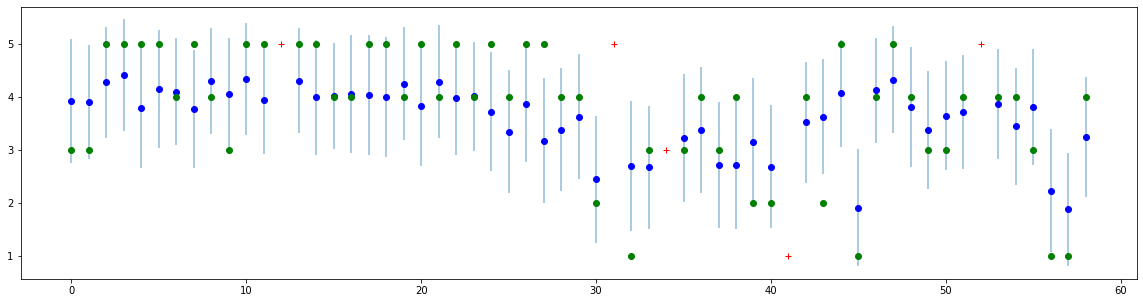

In [53]:
plt.rcParams['figure.figsize'] = 20, 5

mu = mu.numpy().squeeze()
sigma = sigma.numpy().squeeze()
plt.plot(locations, y_context.numpy().squeeze(), 'r+')
plt.plot(rest_locations, mu, 'bo')
plt.plot(rest_locations, y_rest.numpy().squeeze(), 'go')
for i, idx in enumerate(rest_locations):
    plt.vlines(idx, ymin=mu[i] - sigma[i], ymax=mu[i] + sigma[i], alpha=0.5)

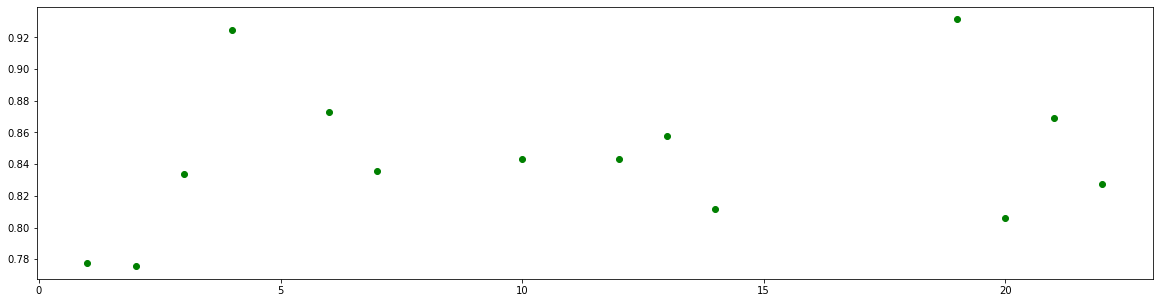

In [210]:
plt.plot(rest_locations, sigma, 'go')

In [197]:
rest_locations

[0, 3, 4, 5, 7, 8, 9, 10, 13, 16, 17, 20, 21, 23]